# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import project_tests as t
import pickle

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('abc')
nltk.download('punkt')

%matplotlib inline


df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']


import warnings
warnings.filterwarnings('ignore', category=pd.core.common.SettingWithCopyWarning)

# Show df to get an idea of the data
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package abc to /root/nltk_data...
[nltk_data]   Package abc is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [3]:
# Print the total number of rows in both dataframes
df_rows = df.shape[0]
df_content_rows = df_content.shape[0]

print("Total rows in df: ", df_rows, "|| Total rows in df_content: ", df_content_rows)

Total rows in df:  45993 || Total rows in df_content:  1056


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [4]:
# group by unique email for interaction data
user_articles_interaction = df.groupby('email')['article_id'].count()

# descriptive statistics 
user_articles_interaction.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

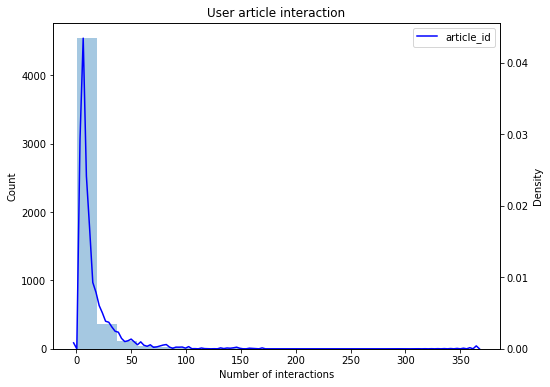

In [5]:
# visual statistics

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize = (8,6))

# Plot the histogram
sns.distplot(user_articles_interaction, bins=20, kde=False, ax=ax1)
ax1.set_xlabel("Number of interactions")
ax1.set_ylabel("Count")
ax1.set_title("User article interaction")

# Create a second y-axis for the KDE plot
ax2 = ax1.twinx()
sns.kdeplot(user_articles_interaction, color='blue', ax=ax2)
ax2.set_ylabel("Density")

plt.show()


In [6]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with 3 number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is 364.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [7]:
# Find and explore duplicate articles

print("Total number of articles: ",df_content_rows)
print("Unique number of articles: ",df_content.article_id.nunique())
print("Number of duplicate articles: ", df_content_rows - df_content.article_id.nunique())

df_content[df_content.duplicated('article_id')]

Total number of articles:  1056
Unique number of articles:  1051
Number of duplicate articles:  5


,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [8]:
# Remove any rows that have the same article_id - only keep the first

df_content.drop_duplicates(['article_id'], inplace = True)

In [9]:
# update number of df_content rows

df_content_rows = df_content.shape[0]
print("updated number of df_content rows: ", df_content_rows)

updated number of df_content rows:  1051


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [10]:
unique_articles = df.article_id.nunique() # The number of unique articles that have at least one interaction
total_articles = df_content.article_id.nunique()# The number of unique articles on the IBM platform
unique_users = df.email[df.email != np.nan].nunique()# The number of unique users
user_article_interactions = len(df[df['email'] != np.nan ][df['article_id'] != np.nan])# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [11]:
df.article_id.value_counts().head(5)

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: article_id, dtype: int64

In [12]:
most_viewed_article_id = "1429.0" # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [13]:
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [14]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [15]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [16]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) The number of top articles to return.
    df - (pandas DataFrame) The DataFrame as defined at the top of the notebook.
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles.
    '''
    
    # Get the top article IDs
    top_ids = get_top_article_ids(n, df)
    
    # Filter the DataFrame for articles in the top IDs
    df_filtered = df[df['article_id'].isin(top_ids)]
    
    # Convert 'article_id' to a categorical type with ordered categories
    df_filtered['article_id'] = pd.Categorical(df_filtered['article_id'], categories=top_ids, ordered=True)
    
    # Sort the DataFrame by 'article_id' to maintain order
    df_sorted_titles = df_filtered.sort_values('article_id')['title']
    
    top_articles = []
    
    # Collect the top 'n' unique article titles
    for val in df_sorted_titles:
        if val not in top_articles:
            top_articles.append(val)
            if len(top_articles) == n: 
                break
                    
    return top_articles  # Return the top article titles from df


def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) The number of top article IDs to return.
    df - (pandas DataFrame) The DataFrame as defined at the top of the notebook.
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article IDs.
    '''
    
    # Get the top article IDs based on interaction counts
    top_ids = df['article_id'].value_counts().index
    
    # Return the top 'n' article IDs as a list
    top_articles = list(top_ids)[:n]
 
    return top_articles  # Return the top article IDs



In [17]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [18]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [19]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - (pandas DataFrame) DataFrame containing columns: article_id, title, user_id.
    
    OUTPUT:
    user_item - (DataFrame) User-item interaction matrix.
    
    DESCRIPTION:
    Returns a matrix with user IDs as rows and article IDs as columns, with values of 1 indicating 
    that a user interacted with an article, and 0 otherwise.
    '''
    
    # Count the number of interactions for each article
    df['interactions'] = df.groupby('article_id')['user_id'].transform('count')
    
    # Create the user-item matrix with interaction counts
    user_item = df.groupby(['user_id', 'article_id'])['interactions'].agg({
        'interaction_counts': lambda x: 1 if x.sum() > 0 else 0
    }).unstack().fillna(0)
    
    # Drop the multi-level index for the columns
    user_item.columns = user_item.columns.droplevel(0)
    
    return user_item  # Return the user-item interaction matrix

# Create the user-item matrix from the DataFrame
user_item = create_user_item_matrix(df)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


In [20]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [21]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    
    similar_user = user_item[user_item.index == user_id ].dot(np.transpose(user_item))
    

    # sort by similarity
    
    most_similar_users = similar_user.sort_values(user_id, axis = 1, ascending = False).columns.tolist()

    # create list of just the ids
    most_similar_users.remove(user_id)
    
    # remove the own user's id
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [22]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [23]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) A list of article IDs.
    df - (pandas DataFrame) The DataFrame containing article information.
    
    OUTPUT:
    article_names - (list) A list of article names corresponding to the provided article IDs 
                     (identified by the title column).
    '''
    
    # Remove duplicate article IDs and retain only relevant columns
    article_df = df.drop_duplicates(subset='article_id')[['article_id', 'title']]
    
    # Convert article IDs to float for comparison
    article_ids_float = [float(article_id) for article_id in article_ids]
    
    # Filter the DataFrame to include only specified article IDs
    filtered_df = article_df[article_df['article_id'].isin(article_ids_float)]
    
    # Set article IDs as a categorical type for ordered sorting
    filtered_df['article_id'] = pd.Categorical(filtered_df['article_id'],
                                                categories=article_ids_float, ordered=True)
    
    # Get sorted article names based on article ID
    article_names = filtered_df.sort_values('article_id')['title'].values.tolist()
    
    return article_names  # Return the list of article names


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) The ID of the user.
    user_item - (pandas DataFrame) User-item matrix indicating interactions (1 for interaction, 0 otherwise).
    
    OUTPUT:
    article_ids - (list) A list of article IDs seen by the user.
    article_names - (list) A list of article names corresponding to the seen article IDs.
    
    DESCRIPTION:
    Provides a list of article IDs and titles that have been seen by a specific user.
    '''
    
    # Select the row corresponding to the user in the user-item matrix
    user_row = user_item.loc[user_id]
    
    # Get the article IDs the user has interacted with
    article_ids = user_row[user_row == 1].index.tolist()
    
    # Convert article IDs to strings
    article_ids = [str(x) for x in article_ids]
    
    # Retrieve the names of the articles
    article_names = get_article_names(article_ids, df)
    
    return article_ids, article_names  # Return the list of IDs and corresponding names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) The ID of the user.
    m - (int) The number of recommendations to provide for the user.
    
    OUTPUT:
    recs - (list) A list of recommended article IDs for the user.
    
    DESCRIPTION:
    Iterates through similar users to find articles the specified user has not seen and provides recommendations.
    Stops once the desired number of recommendations (m) has been reached.
    
    NOTES:
    Similar users are chosen arbitrarily if they have the same closeness score.
    If the number of recommended articles starts below m and ends exceeding m, 
    the last items are selected arbitrarily.
    '''
    
    # Retrieve the list of similar users
    similar_users = find_similar_users(user_id, user_item)
    
    # Get the set of article IDs that the user has already viewed
    user_article_ids = set(get_user_articles(user_id, user_item)[0])
    
    recs = []  # Initialize recommendations list
    seen_recs = set()  # Track articles already recommended
    
    # Loop through similar users to find potential recommendations
    for similar_user in similar_users:
        similar_article_ids = get_user_articles(similar_user, user_item)[0]
        
        for article_id in similar_article_ids:
            # Recommend only unseen articles
            if article_id not in user_article_ids and article_id not in seen_recs:
                recs.append(article_id)
                seen_recs.add(article_id)
                
                # Stop once we've gathered m recommendations
                if len(recs) == m:
                    return recs
    
    return recs  # Return the recommendations for the specified user ID


In [24]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

In [25]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [26]:
def get_filtered_top_articles(m, recs, df=df):
    '''
    INPUT:
    m - (int) The number of top articles to return.
    recs - (list) A list of recommended article IDs.
    df - (pandas DataFrame) The DataFrame containing article information.
    
    OUTPUT:
    top_ids - (list) A list of the top article IDs based on the recommendations.
    top_filtered_articles - (list) A list of article titles corresponding to the top article IDs.
    
    DESCRIPTION:
    Filters the DataFrame for the top articles based on the recommended articles and returns the top 'm' articles.
    '''
    
    # Get article IDs from the recommendations and count their occurrences in the DataFrame
    top_ids = df[df['article_id'].isin(recs)]['article_id'].value_counts().index
    
    # Filter the DataFrame to include only the top article IDs
    df_filtered = df[df['article_id'].isin(top_ids)]
    
    # Set article IDs as a categorical type for ordered sorting
    df_filtered['article_id'] = pd.Categorical(df_filtered['article_id'], 
                                                categories=top_ids, ordered=True)
    
    # Sort the titles based on article ID
    df_sorted_titles = df_filtered.sort_values('article_id')['title']
    
    top_filtered_articles = []  # Initialize the list for filtered article titles
    
    # Collect unique article titles until we reach the desired count (m)
    for title in df_sorted_titles:
        if title not in top_filtered_articles:
            top_filtered_articles.append(title)
            if len(top_filtered_articles) == m:
                break
    
    # Get the top article IDs limited to 'm'
    top_ids = top_ids.tolist()[:m]
    
    return top_ids, top_filtered_articles  # Return the top article IDs and titles


In [27]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int) The ID of the user for whom to find similar users.
    df - (pandas DataFrame) The DataFrame containing user-article interactions.
    user_item - (pandas DataFrame) A matrix of users by articles: 
                1's indicate interaction with an article, 0's otherwise.
    
    OUTPUT:
    neighbors_df - (pandas DataFrame) A DataFrame containing:
                    - neighbor_id: The ID of the neighbor user.
                    - similarity: A measure of similarity to the specified user.
                    - num_interactions: The number of articles viewed by the neighbor user.
                    
    DESCRIPTION:
    Sorts the neighbors_df by similarity and number of interactions, with higher values first.
    '''
    
    # Initialize the DataFrame to hold neighbor information
    neighbors_df = pd.DataFrame(columns=['neighbor_id', 'similarity', 'num_interactions'])
    
    # Populate neighbor_id for all users except the specified user_id
    neighbors_df['neighbor_id'] = [user for user in range(1, user_item.shape[0]) if user != user_id]
    
    # Calculate similarity for each neighbor user using dot product
    neighbors_df['similarity'] = neighbors_df.neighbor_id.apply(lambda x: np.dot(user_item.loc[user_id], user_item.loc[x]))
    
    # Calculate the number of interactions for each neighbor
    num_interactions = df.groupby('user_id')['article_id'].count()
    neighbors_df['num_interactions'] = neighbors_df.neighbor_id.apply(lambda x: num_interactions.loc[x].sum())
    
    # Sort the DataFrame by similarity and number of interactions
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False, inplace=True)
    
    # Reset index and drop the old index column
    neighbors_df.reset_index(drop=True, inplace=True)
    
    return neighbors_df  # Return the DataFrame of sorted neighbors


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) The ID of the user for whom to generate recommendations.
    m - (int) The number of recommendations to return for the user.
    
    OUTPUT:
    recs - (list) A list of recommended article IDs for the user.
    rec_names - (list) A list of recommended article titles for the user.
    
    DESCRIPTION:
    Loops through similar users to find articles that the user hasn't seen,
    providing recommendations until 'm' recommendations are found.
    
    NOTES:
    - Prioritize users with the most article interactions.
    - Prefer articles with the highest number of interactions.
    '''
    
    # Get sorted neighbors based on similarity
    neighbors_df = get_top_sorted_users(user_id)
    
    # Get the set of article IDs that the user has already seen
    user_article_ids = set(get_user_articles(user_id, user_item)[0])

    recs = np.array([])  # Initialize an empty array for recommendations
    
    # Loop through the sorted neighbor users to find recommendations
    for user in neighbors_df.neighbor_id:
        similar_article_ids = get_user_articles(user, user_item)[0]
        
        # Find new recommendations that the user hasn't seen
        new_recs = np.setdiff1d(similar_article_ids, user_article_ids, assume_unique=True)
        final_recs = np.setdiff1d(new_recs, recs, assume_unique=True)
        
        # Combine new recommendations with existing ones
        recs = np.concatenate([final_recs, recs], axis=0)
        
        # Stop if we've reached the desired number of recommendations
        if len(recs) >= m:
            break
    
    # Get filtered top articles from the recommendations
    recs, rec_names = get_filtered_top_articles(m, df=df, recs=recs)
    
    return recs, rec_names  # Return the recommendations and their names


In [28]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [29]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).neighbor_id.loc[0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).neighbor_id.loc[9]# Find the 10th most similar user to user 131

In [30]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

<b>This scenario illustrates the cold start problem, where we lack information about a new user. Without any user data, collaborative filtering methods are ineffective because they rely on past interactions and user similarities. Instead, we can turn to other recommendation strategies such as knowledge-based recommendations or popularity-based rankings. For example, we can offer new users the most frequently read articles. Using the top_articles function, we can easily provide these popular article recommendations.</b>

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [31]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = list(map(str, get_top_article_ids(10)))# Your recommendations here



In [32]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [33]:
def tokenize_text(text):
    """
    Tokenize a string into words.
    
    Inputs:
        text (str): String to tokenize.
            
    Outputs:
        list: List of lemmatized words.
    """
    # Get stop words
    stop_words = set(stopwords.words('english')) | set(nltk.corpus.abc.words())
    
    # Split the text into individual words
    tokens = word_tokenize(text)
    
    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Clean and lemmatize each token
    clean_tokens = [
        lemmatizer.lemmatize(token).lower().strip() 
        for token in tokens
    ]
    
    # Filter out stop words and non-alphabetic tokens
    filtered_tokens = [
        word for word in clean_tokens 
        if word not in stop_words and word.isalpha()
    ]
    
    return filtered_tokens

def generate_content_recommendations(entity_id, is_user=True, num_recommendations=10, df=df):
    """
    Generate content-based recommendations based on article titles.
    
    Inputs:
        entity_id (str): ID of either a user or an article.
        is_user (bool): If True, make recommendations based on user history.
        num_recommendations (int): Number of recommendations to generate.
    
    Outputs:
        list: List of recommended article IDs.
        list: List of recommended article titles.
    """
    if is_user:
        user_id = entity_id
        try:
            # Get articles read by the user
            user_article_ids, _ = get_user_articles(user_id)
        except KeyError:
            # User does not exist, recommend top articles
            print("User doesn't exist, recommending top articles.")
            top_recs = get_top_article_ids(num_recommendations)
            return top_recs, get_article_names(top_recs)
    else:
        user_article_ids = entity_id
    
    # Drop duplicate articles and get titles for the specified articles
    unique_articles = df.drop_duplicates(subset='article_id')
    user_titles = unique_articles[unique_articles.article_id.isin(map(float, user_article_ids))].title
    
    # Tokenize the words in each article title
    tokenized_titles = tokenize_text(user_titles.str.cat(sep=' '))
    
    # Find the most common words
    common_words = pd.value_counts(tokenized_titles).sort_values(ascending=False)[:10].index
    
    top_matches = {}
    # Measure of similarity: count the number of occurrences of each common word in other article titles
    for word in common_words:
        word_count = pd.Series(unique_articles.title.str.count(word).fillna(0))
        top_matches[word] = word_count
    
    # Most common words
    top_matches_df = pd.DataFrame(top_matches)
    top_matches_df['total_matches'] = top_matches_df.sum(axis=1)
    top_matches_df['article_id'] = unique_articles.article_id.astype(float)
    
    # Get the most interacted with articles
    article_occurrences = pd.DataFrame({'occurrences': df.article_id.value_counts()})

    # Sort matches by the most popular articles
    top_matches_df = top_matches_df.merge(article_occurrences, left_on='article_id', right_index=True)
    top_matches_df.sort_values(['total_matches', 'occurrences'], ascending=False, inplace=True)    
    
    # Drop already read articles
    recommended_articles_df = top_matches_df[~top_matches_df.article_id.isin(map(float, user_article_ids))]
    
    # Get recommended article IDs and titles
    recommended_article_ids = list(recommended_articles_df.article_id[:num_recommendations].values.astype(str))
    recommended_article_titles = get_article_names(recommended_article_ids)
    
    return recommended_article_ids, recommended_article_titles


`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

* This content-based recommender analyzes articles that users have previously interacted with. By leveraging the NLTK library, it identifies the most frequently occurring words in each article's title. Based on these common words, the system evaluates the relevance of words in the titles of all articles and provides recommendations based on the number of matches and the overall popularity of the articles.

* If a user has not engaged with any articles yet, the recommender is unable to provide content-based suggestions and will return a selection of the most popular articles instead.

* There is significant potential for enhancing this recommender. For instance, creating a custom NLTK corpus could help filter out less relevant words from the articles. Currently, a combination of standard NLTK corpora is utilized. Additionally, if the content DataFrame contained information on all articles, the recommender could be expanded to consider not only titles but also the full text of the articles

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [34]:
# make recommendations for a brand new user
generate_content_recommendations(0, is_user = True)


User doesn't exist, recommending top articles.


([1429.0,
  1330.0,
  1431.0,
  1427.0,
  1364.0,
  1314.0,
  1293.0,
  1170.0,
  1162.0,
  1304.0],
 ['use deep learning for image classification',
  'insights from new york car accident reports',
  'visualize car data with brunel',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'predicting churn with the spss random tree algorithm',
  'healthcare python streaming application demo',
  'finding optimal locations of new store using decision optimization',
  'apache spark lab, part 1: basic concepts',
  'analyze energy consumption in buildings',
  'gosales transactions for logistic regression model'])

In [35]:

# make a recommendations for a user who only has interacted with article id '1427.0'

generate_content_recommendations(['1330.0'], is_user=False)

(['213.0',
  '1114.0',
  '1116.0',
  '1429.0',
  '1431.0',
  '1427.0',
  '1364.0',
  '1314.0',
  '1293.0',
  '1170.0'],
 ['modeling energy usage in new york city',
  'airbnb data for analytics: new york city calendar',
  'airbnb data for analytics: new york city reviews',
  'use deep learning for image classification',
  'visualize car data with brunel',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'predicting churn with the spss random tree algorithm',
  'healthcare python streaming application demo',
  'finding optimal locations of new store using decision optimization',
  'apache spark lab, part 1: basic concepts'])

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [36]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [37]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [38]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

In [39]:
print("Number of Nans in the users to item interactions matrix is: {}".format(np.isnan(user_item_matrix).sum().sum()))
print("Number of Nans in the users to latent features matrix is: {}".format(np.isnan(u).sum().sum()))
print("Number of Nans in the segma matrix is: {}".format(np.isnan(s).sum().sum()))
print("Number of Nans in the items to latent features matrix is: {}".format(np.isnan(vt).sum().sum()))

Number of Nans in the users to item interactions matrix is: 0
Number of Nans in the users to latent features matrix is: 0
Number of Nans in the segma matrix is: 0
Number of Nans in the items to latent features matrix is: 0


**Provide your response here.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

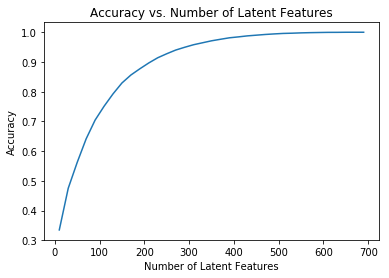

In [40]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [41]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here

    # Create user-item matrix for the training dataset
    user_item_train = create_user_item_matrix(df_train)
    
    # Create user-item matrix for the test dataset
    user_item_test = create_user_item_matrix(df_test)
    
    # Get the user IDs from the training dataset
    train_idx = user_item_train.index
    
    # Get the user IDs from the test dataset
    test_idx = user_item_test.index
    
    # Find the common user IDs between the training and test datasets
    shared_rows = train_idx.intersection(test_idx)
    
    # Get the article IDs from the training dataset
    train_arts = user_item_train.columns
    
    # Get the article IDs from the test dataset
    test_arts = user_item_test.columns
    
    # Find the common article IDs between the training and test datasets
    shared_cols = train_arts.intersection(test_arts)
    
    # Create a new user-item matrix for the test dataset with only the common users and articles
    user_item_test = user_item_test.loc[shared_rows, shared_cols]
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


In [44]:
#How many users can we make predictions for in the test set?
num_test_pred = set(test_idx)&set(user_item_train.index) 
print("Test users we can make prediction for: ",len(num_test_pred))

#How many users in the test set are we not able to make predictions for because of the cold start problem?
cold_start_test =  set(test_idx) - set(user_item_train.index)
print("Test users we cannot make prediction for because of cold start problem: ",len(cold_start_test))

Test users we can make prediction for:  20
Test users we cannot make prediction for because of cold start problem:  662


In [45]:
#How many articles can we make predictions for in the test set?
test_art_pred = set(test_arts)&set(user_item_train.columns) 
print("number of articles we can make prediction for: ",len(test_art_pred))


#How many articles in the test set are we not able to make predictions
test_art_pred = set(test_arts)-set(user_item_train.columns) 
print("number of articles we cannot make prediction for: ",len(test_art_pred))

number of articles we can make prediction for:  574
number of articles we cannot make prediction for:  0


In [46]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,# letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?':a ,# letter here, 
    'How many articles can we make predictions for in the test set?':b, # letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [47]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

In [48]:
def svd_algorithm(u_train, s_train, vt_train):
    """ 
    Perform Singular Value Decomposition (SVD) to predict on test data and evaluate accuracy.
    
    Inputs:
        u_train (np.array): User-item interaction matrix (U matrix from SVD)
        s_train (np.array): Sigma matrix (diagonal matrix with singular values from SVD)
        vt_train (np.array): V transpose matrix (V^T matrix from SVD)
            
    Outputs:
        None: Plots accuracy for train and test data vs number of latent features
    """
    
    # Define the range of latent features to test
    num_latent_features = np.arange(10, 710, 20)
    train_errors = []
    test_errors = []
    total_errors = []

    # Iterate over the range of latent features
    for k in num_latent_features:
        
        # Identify indices for train and test data
        train_indices = user_item_train.index.isin(test_idx)
        test_indices = user_item_train.columns.isin(test_arts)
        u_test = u_train[train_indices, :]
        vt_test = vt_train[:, test_indices]
        
        # Decompose matrices for the top k latent features
        s_k, u_k, vt_k = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
        u_test_k, vt_test_k = u_test[:, :k], vt_test[:k, :]

        # Predict user-item interactions
        user_item_train_preds = np.around(np.dot(np.dot(u_k, s_k), vt_k))
        user_item_test_preds = np.around(np.dot(np.dot(u_test_k, s_k), vt_test_k))
        
        # Calculate the total error for all predictions
        total_error = 1 - ((np.sum(user_item_test_preds) + np.sum(np.sum(user_item_test))) / 
                           (user_item_test.shape[0] * user_item_test.shape[1]))
        total_errors.append(total_error)

        # Calculate the error for each prediction
        train_diffs = np.subtract(user_item_train, user_item_train_preds)
        test_diffs = np.subtract(user_item_test, user_item_test_preds)

        # Sum the absolute errors
        train_error = np.sum(np.sum(np.abs(train_diffs)))
        test_error = np.sum(np.sum(np.abs(test_diffs)))

        # Store the errors
        train_errors.append(train_error)
        test_errors.append(test_error)
        
    # Plot the accuracy for train and test data vs number of latent features
    plt.figure(figsize=(15, 10))

    plt.plot(num_latent_features, 1 - np.array(train_errors) / (user_item_train.shape[0] * user_item_train.shape[1]), 
             label='Train', color='darkred')
    plt.plot(num_latent_features, 1 - np.array(test_errors) / (user_item_test.shape[0] * user_item_test.shape[1]), 
             label='Test', color='darkblue')
    plt.plot(num_latent_features, total_errors, label='Total Error', color="orange")
    
    plt.xlabel('Number of Latent Features')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs. Number of Latent Features')
    plt.show()


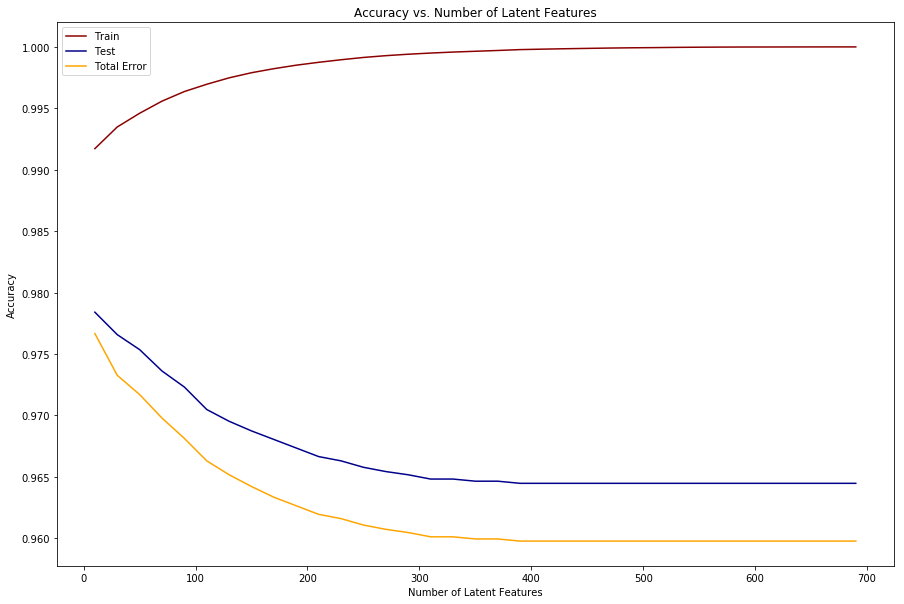

In [49]:
svd_algorithm(u_train, s_train, vt_train)

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

`<b>1) Observation:</b>`
* The training accuracy improves with an increased number of latent features.
* The test accuracy starts to decrease as more latent features are added.



`<b>2)Analysis:</b>`
* There are only 20 shared user IDs between the training and testing datasets.
* This limited overlap indicates insufficient data to effectively test the recommendation system.
* The reduced test accuracy for a higher number of latent features highlights the data sparsity issue.


`<b>3)Recommendation:</b>`
* Given the current data limitations, I suggest implementing a hybrid recommendation system:
* Ranked-based Recommendation Engine: To address the cold start problem.
* Collaborative Filtering or SVD: For more personalized recommendations once sufficient data is available.
* To determine the optimal approach (SVD vs. Collaborative Filtering), an A/B test experiment should be conducted to compare their performance and choose the most effective method.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [51]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0